In [1]:
import os

import torch
import xarray as xr
import numpy as np

/perm/syma/conda-envs/shared/gnn-pyg-2.1/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cf

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
var = "t"

In [4]:
pred_file = "/ec/res4/scratch/syma/GNN/WeatherBench/predictions/wb_pred_gnn.nc"

ds_pred = xr.open_dataset(pred_file)
ds_pred

<xarray.Dataset>
Dimensions:    (latitude: 181, longitude: 360, level: 13, time: 20, rollout: 4)
Coordinates:
  * latitude   (latitude) float32 -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
  * longitude  (longitude) float32 -180.0 -179.0 -178.0 ... 177.0 178.0 179.0
  * level      (level) int32 50 100 150 200 250 300 400 500 600 700 850 925 1000
  * time       (time) datetime64[ns] 2020-01-07T12:00:00 ... 2020-08-14T18:00:00
  * rollout    (rollout) int32 0 1 2 3
Data variables:
    z          (time, level, latitude, longitude, rollout) float32 ...
    t          (time, level, latitude, longitude, rollout) float32 ...
    q          (time, level, latitude, longitude, rollout) float32 ...
    w          (time, level, latitude, longitude, rollout) float32 ...
    u          (time, level, latitude, longitude, rollout) float32 ...
    v          (time, level, latitude, longitude, rollout) float32 ...

In [5]:
IDX_TO_CHECK = (3, 18)

In [6]:
tpts = ds_pred[var].time[list(IDX_TO_CHECK)]
tpts

<xarray.DataArray 'time' (time: 2)>
array(['2020-04-16T06:00:00.000000000', '2020-07-26T06:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-04-16T06:00:00 2020-07-26T06:00:00
Attributes:
    long_name:  time

In [7]:
a = 6*3.6e12
np.timedelta64(int(a), "ns")

numpy.timedelta64(21600000000000,'ns')

In [8]:
import datetime as dt
tpts_p1 = tpts + np.timedelta64(int(6*3.6e12), "ns")
tpts_p1

<xarray.DataArray 'time' (time: 2)>
array(['2020-04-16T12:00:00.000000000', '2020-07-26T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-04-16T06:00:00 2020-07-26T06:00:00

In [9]:
ground_truth_file = "/ec/res4/hpcperm/syma/WeatherBench/netcdf/test/pl_2020.nc"

ds_truth = xr.open_dataset(ground_truth_file)
ds_truth = ds_truth.assign_coords({"longitude": (((ds_truth.longitude + 180) % 360) - 180.0)})
ds_truth = ds_truth.sortby("longitude").sortby("latitude")

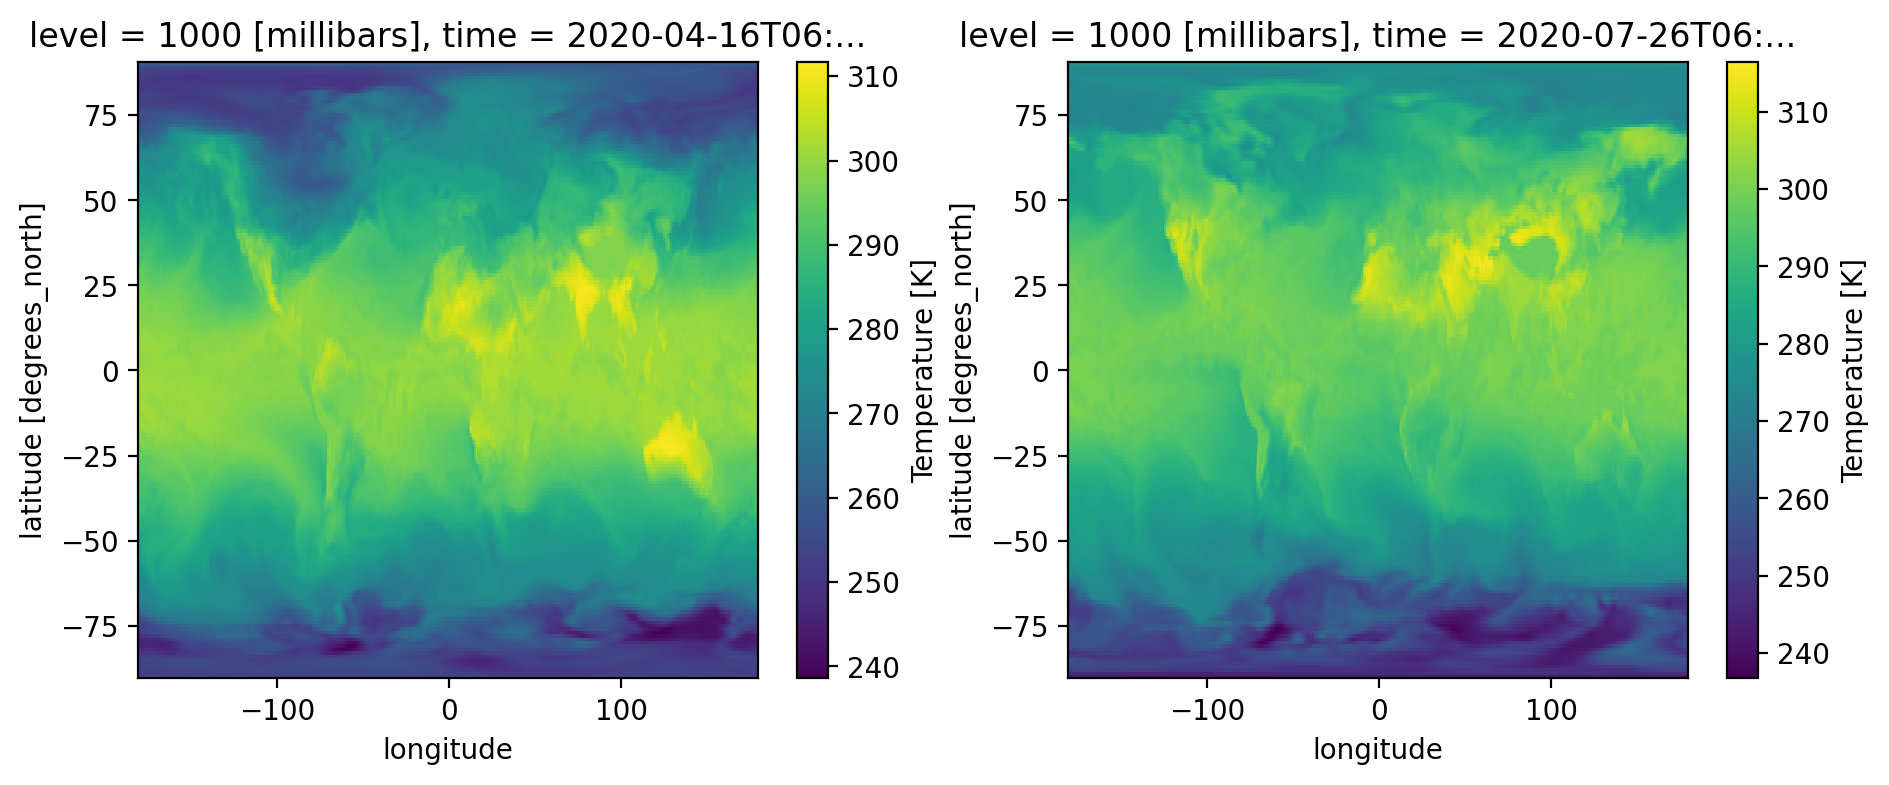

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(11, 4))

ds_truth[var].sel(time=tpts[0],level=1000).plot(ax=ax[0])
ds_truth[var].sel(time=tpts[1],level=1000).plot(ax=ax[1])

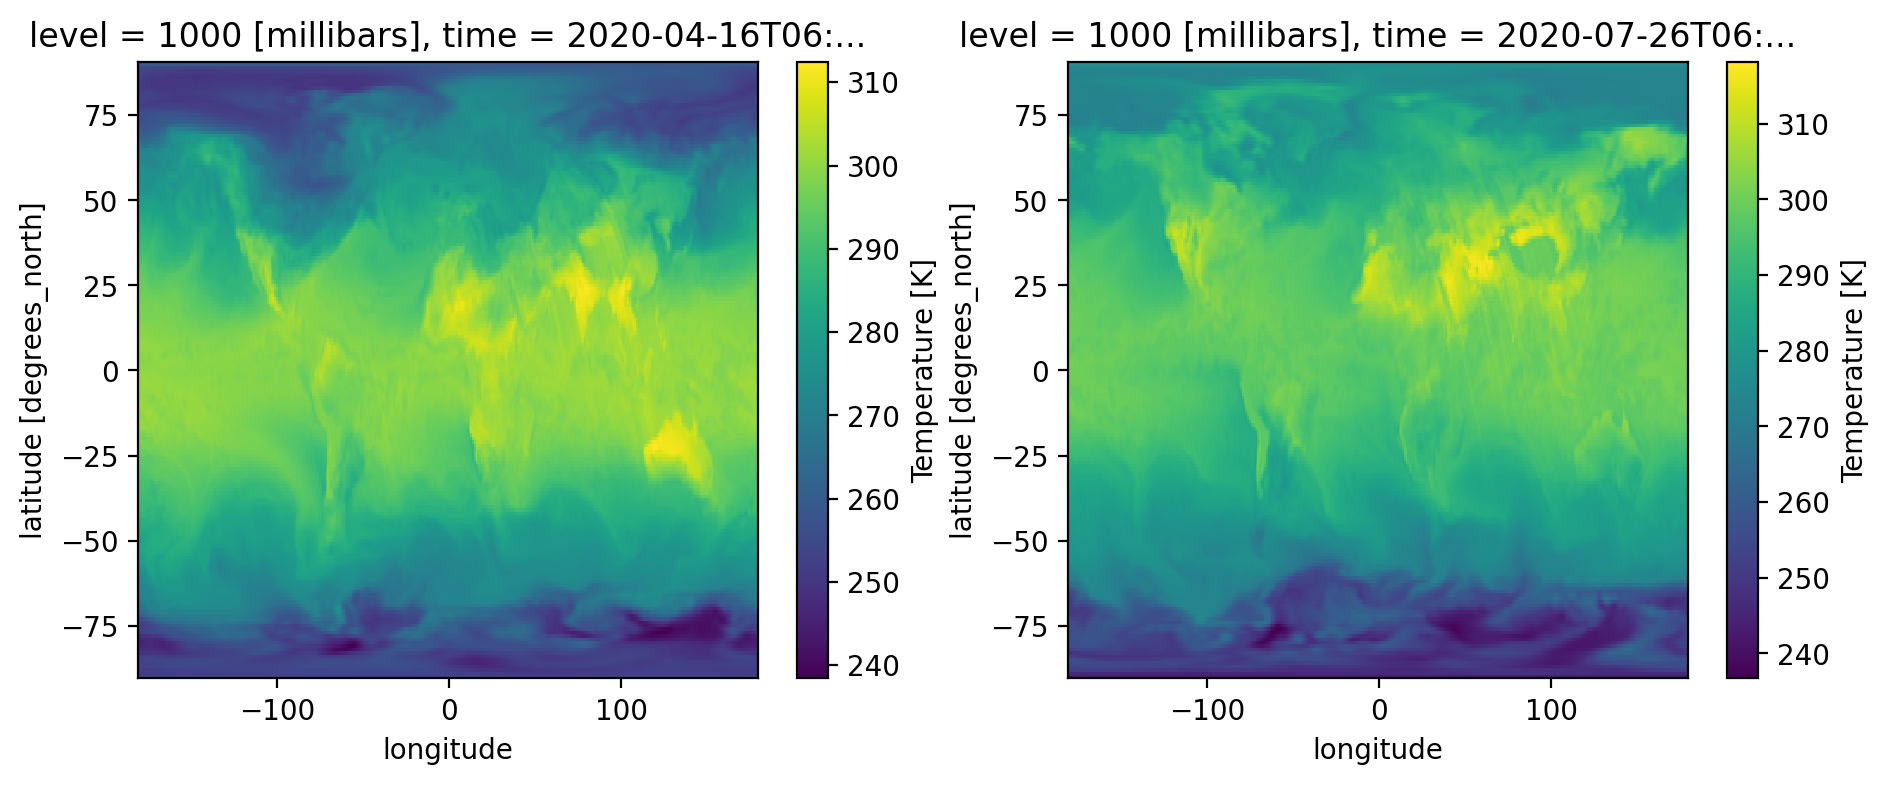

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(11, 4))

ds_pred[var].sel(time=tpts[0],level=1000, rollout=0).plot(ax=ax[0])
ds_pred[var].sel(time=tpts[1],level=1000, rollout=0).plot(ax=ax[1])

In [12]:
truth = ds_truth[var].sel(time=tpts_p1,level=1000).drop("level").load()
preds = ds_pred[var].isel(time=list(IDX_TO_CHECK),level=-1,rollout=0).drop(("rollout", "level")).load()

In [13]:
tpts

<xarray.DataArray 'time' (time: 2)>
array(['2020-04-16T06:00:00.000000000', '2020-07-26T06:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-04-16T06:00:00 2020-07-26T06:00:00
Attributes:
    long_name:  time

In [14]:
diff = truth.values - preds.values
diff.min(), diff.max()

(-19.561218, 13.12439)

In [16]:
from typing import Optional

def plot_2d_field(data: np.ndarray, cmap: str = "viridis", cbar: bool = True, title: Optional[str] = None) -> None:
    assert len(data.shape) == 2, f"Need a 2D field to plot! Shape of data array: {data.shape}"
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
    im = ax.imshow(data, aspect="auto", cmap=cmap, origin="lower")
    if cbar:
        # add space for colour bar
        fig.subplots_adjust(right=0.85)
        cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
        fig.colorbar(im, cax=cbar_ax)
        if title is not None:
            ax.set_title(title)
    plt.show()

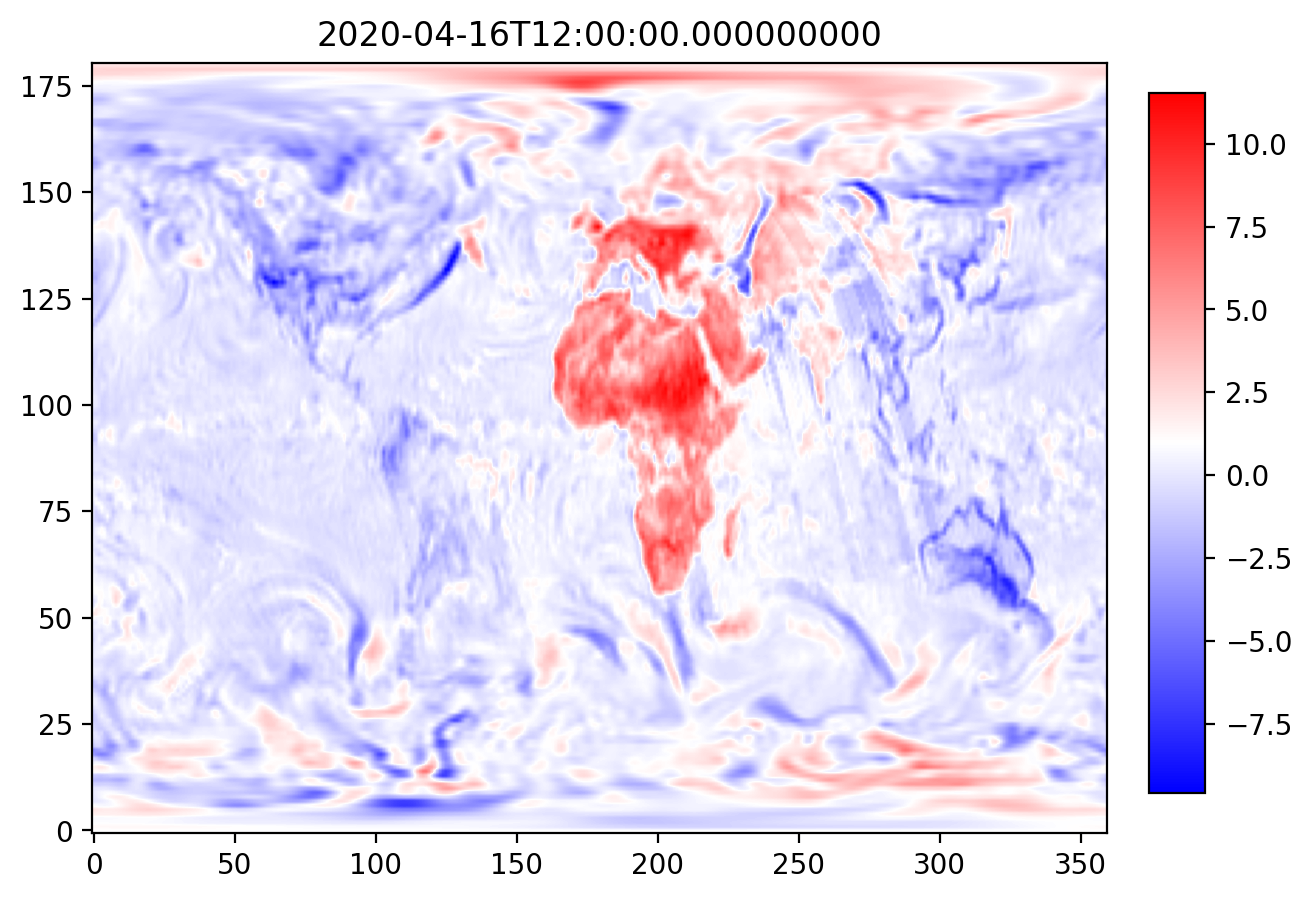

In [18]:
plot_2d_field(truth.values[0, ...] - preds.values[0, ...], cmap="bwr", title=truth.time[0].values)

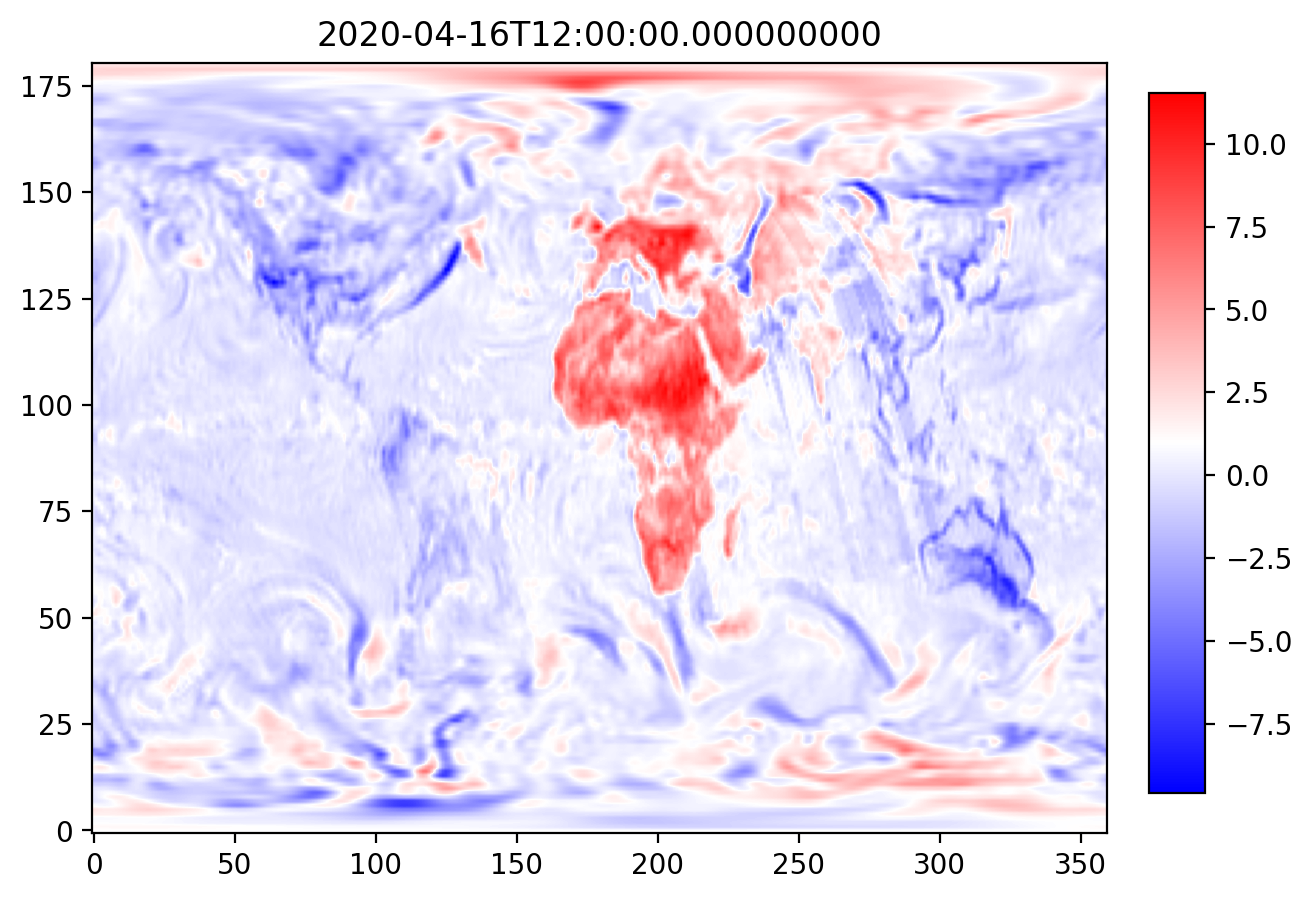

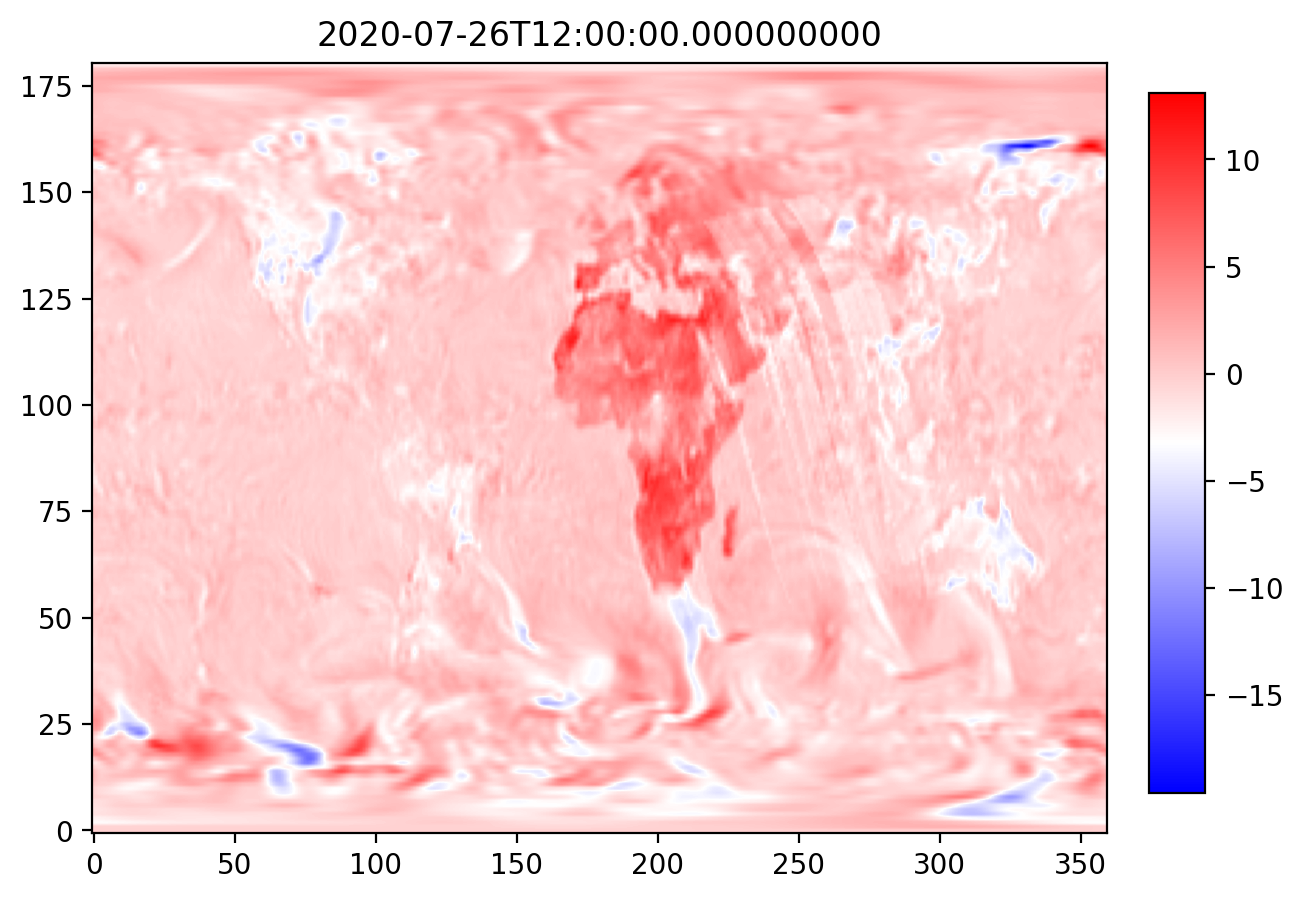

In [17]:
plot_2d_field(diff[0, ...].squeeze(), cmap="bwr", title=truth.time[0].values)
plot_2d_field(diff[1, ...].squeeze(), cmap="bwr", title=truth.time[1].values);